# A/B Testing: Player Retention for Mobile Game

## Table of Contents

1. [Intorduction and Context](#1)
2. [Imports and Helpers](#2)
3. [Data](#3)
4. [Exploratory Data Analysis](#4)
5. [arst](#5)

## 1. Introduction and Context <a name='1'></a>

This is a [mini project](datacamp.com/projects/184) from [DataCamp](datacamp.com). 

### Project Description from DataCamp:

[Cookie Cats](https://tactilegames.com/cookie-cats/) is a hugely popular mobile puzzle game developed by [Tactile Entertainment](https://tactilegames.com). It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

**As players progress through the game they will encounter gates that force them to wait some time before they can progress or alternatively make an in-app purchase to progress. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.**

🍪 🐈 🍪 🐈 🍪 🐈

### Problem Statement

Should the proposed gate at Level 40 be implemented over the existing gate at Level 40 based on day 1 and 7 player retention rates.

### Data Descriptions

The dataset contains is from 90,189 players that installed the game while the AB Test was running. 

Dataset labels:
- `userid` - `int` - unique player identifier.
- `version` - `str` - group the player was randomly assigned to: control (`gate_30` .- gate at Level 30) or treatment (`gate_40` - gate at Level 40).
- `sum_gamerounds` - `int` - total number of games played by the player during the first week after installation.
- `retention_1` - `bool` - `True` if the player played 1 day after installing else `False`.
- `retention_7` - `bool` - `True` if the player played 7 days after installing else `False`.

## 2. Imports and Helpers<a name='2'></a>

In [56]:
# PyData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Hypothesis Testing
import scipy.stats as stats

In [57]:
%matplotlib inline
sns.set_palette('colorblind')

In [51]:
# Helper Functions

def infoplus(df):
    '''Returns an expanded form of pandas .info() to include,
    shape, null count, null% and unique count'''
    infod = {'col_ind': [], 'col_name': [], 'non_null': [], 'null': [],
             'null_per': [], 'unique': [],'dtype': []}
    max_len = []

    for i, col in enumerate(df.columns):
        infod['col_ind'].append(i)
        infod['col_name'].append(col)
        infod['non_null'].append(df[col].value_counts().sum())
        infod['null'].append(df[col].isna().sum())
        infod['null_per'].append(round(infod['null'][-1] / len(df), 5))
        infod['unique'].append(len(df[col].unique()))
        infod['dtype'].append(str(df[col].dtype))

    for key in infod.keys():
        max_len.append(len(max(map(str, infod[key]), key=len)))
    for i, key in enumerate(infod.keys()):
        max_len[i] = max(len(key), max_len[i])
    if max_len[4] > 6:
        max_len[4] = 6

    OFFSET = 2
    print(type(df))
    print(f'Range Index: {len(df)} entries, {df.index[0]} to {df.index[-1]}')
    print(f'Shape: {df.shape}')
    print(f'''\
{'#': ^{max_len[0] + OFFSET - 2}}\
{'Column': <{max_len[1]}}\
{'Non-Null': >{max_len[2] + OFFSET}}\
{'Null': >{max_len[3] + OFFSET}}\
{'% Null': >{max_len[4] + OFFSET}}\
{'Unique': >{max_len[5] + OFFSET}}  \
{'dtype': <{max_len[6] + OFFSET}}\
''')
    print(f'''\
{'-' * (max(3, max_len[0]) - 2): ^{max_len[0] + OFFSET - 2}}\
{'-' * max_len[1]: <{max_len[1]}}\
{'-' * max_len[2]: >{max_len[2] + OFFSET}}\
{'-' * max_len[3]: >{max_len[3] + OFFSET}}\
{'-' * max_len[4]: >{max_len[4] + OFFSET}}\
{'-' * max_len[5]: >{max_len[5] + OFFSET}}  \
{'-' * max_len[6]: <{max_len[6] + OFFSET}}\
''')
    for i in infod['col_ind']:
        print(f'''{str(infod['col_ind'][i]): ^{max(3, max_len[0] + OFFSET - 2)}}\
{infod['col_name'][i]: <{max_len[1]}}\
{infod['non_null'][i]: >{max_len[2] + OFFSET}}\
{infod['null'][i]: >{max_len[3] + OFFSET}}\
{f"{infod['null_per'][i] * 100: .2f}": >{max_len[4] + OFFSET}}\
{infod['unique'][i]: >{max_len[5] + OFFSET}}  \
{infod['dtype'][i]: <{max_len[6] + OFFSET}}\
              ''')
    
    dtypes = [dtype for dtype in set(infod['dtype'])]
    for dtype in dtypes:
        dtype_count = [f"{dtype}({infod['dtype'].count(dtype)})" for dtype in dtypes]
    print(f"dtypes: {', '.join(dtype_count)}")
    print(f'memory usage: {byte_conversion(df.memory_usage().sum())}')
    
# Helper
def byte_conversion(df_mem):
    '''Converts bytes to readable magnitude, used in infoplus()'''
    ending_dict = {1: 'B', 2: 'KB', 3: 'MB', 4: 'GB'}
    power = 1
    while df_mem / (1024 ** power) > 1:
        power += 1
        if power == 4:
            break
    return f'{df_mem / (1024 ** (power - 1)): .2f} {ending_dict[power]}'

## 3. Data <a name='3'></a>

In [52]:
data = pd.read_csv('../raw_data/cookie_cats.csv')

data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [53]:
# Check dataframe shape, null counts and unique values, datatypes
infoplus(data)

<class 'pandas.core.frame.DataFrame'>
Range Index: 90189 entries, 0 to 90188
Shape: (90189, 5)
   #   Column          Non-Null  Null  % Null  Unique  dtype   
 ----- --------------  --------  ----  ------  ------  ------  
   0   userid             90189     0    0.00   90189  int64                 
   1   version            90189     0    0.00       2  object                
   2   sum_gamerounds     90189     0    0.00     942  int64                 
   3   retention_1        90189     0    0.00       2  bool                  
   4   retention_7        90189     0    0.00       2  bool                  
dtypes: bool(2), object(1), int64(2)
memory usage:  2.24 MB


In [54]:
# Check duplicates within data frame and duplicated users

data.duplicated().sum(), data['userid'].duplicated().sum()

(0, 0)

Observations:
- There are no null values.
- `version`, `retention_1` and `retention_7` have binary values as expected.
- There are no duplicate entries or duplicated users.
- Data is generally clean and ready to use.

## 4. Exploratory Data Analysis <a name='4'></a>

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


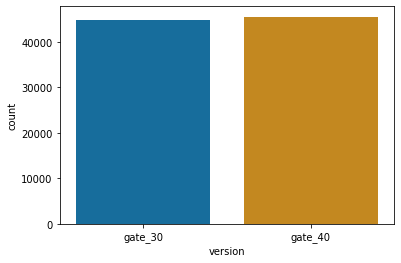

In [55]:
# Coount of players in control and treatment group w/ visualisation

display(data.groupby('version').count())

sns.countplot(x='version', data=data)
plt.show()